In [1]:
import pandas as pd
import numpy as np
from sklearnex import patch_sklearn
patch_sklearn()

import sys
import os

Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)


In [2]:
# Setting path to load util functions
from pathlib import Path
parent_dir = Path.cwd().parents[3]
sys.path.append(os.path.abspath(parent_dir))

In [3]:
train_df = pd.read_parquet('../../../../data/final_features_ml/train_all_features_last_month.parquet')
val_df = pd.read_parquet('../../../../data/final_features_ml/val_all_features_last_month.parquet')
test_df = pd.read_parquet('../../../../data/final_features_ml/test_all_features_last_month.parquet')

y_train = pd.read_parquet('../../../../data/3d_array/train_targets.parquet')
y_val = pd.read_parquet('../../../../data/3d_array/val_targets.parquet')
y_test = pd.read_parquet('../../../../data/3d_array/test_targets.parquet')

In [4]:
train_df.sort_values(by = ['customer_ID'], inplace=True)
y_train.sort_values(by = ['customer_ID'], inplace=True)
val_df.sort_values(by = ['customer_ID'], inplace=True)
y_val.sort_values(by = ['customer_ID'], inplace=True)
test_df.sort_values(by = ['customer_ID'], inplace=True)
y_test.sort_values(by = ['customer_ID'], inplace=True)

In [5]:
train_df.shape, y_train.shape, val_df.shape, y_val.shape, test_df.shape, y_test.shape

((289115, 426),
 (289115, 3),
 (32124, 426),
 (32124, 3),
 (137674, 426),
 (137674, 3))

In [6]:
train_df.reset_index(drop=True, inplace=True)
y_train.reset_index(drop=True, inplace=True)
val_df.reset_index(drop=True, inplace=True)
y_val.reset_index(drop=True, inplace=True)
test_df.reset_index(drop=True, inplace=True)
y_test.reset_index(drop=True, inplace=True)

In [7]:
import time
from hyperopt import fmin, tpe, hp, STATUS_OK, STATUS_FAIL, Trials, space_eval
from sklearn.metrics import recall_score, classification_report
from sklearn.base import ClassifierMixin # To ensure model has fit/predict
from typing import Dict, Any, Type, Tuple

import mlflow
from utils.threshold import find_threshold_binary_search

# Define types for clarity (optional but good practice)
DataType = Tuple[pd.DataFrame | np.ndarray, pd.Series | np.ndarray]

def tune_model_recall_constrained(
    model_cls: Type[ClassifierMixin],
    param_space: Dict[str, Any],
    train_data: DataType,
    val_data: DataType,
    primary_target_class: int,        # Class to MAXIMIZE recall for (e.g., 1)
    constraint_class: int,            # Class to apply recall CONSTRAINT on (e.g., 0)
    constraint_recall_level: float,   # Minimum recall for constraint_class (e.g., 0.98)
    max_evals: int = 50,
    mlflow_experiment_name: str = "HP Tuning Constrained Recall",
    mlflow_run_name: str = "Constrained Recall Opt Run",
    random_state: int | None = 42
) -> Dict[str, Any]:
    """
    Performs hyperparameter tuning optimizing recall for 'primary_target_class',
    subject to a minimum recall constraint on 'constraint_class'.

    Args:
        model_cls: Classifier class.
        param_space: Hyperopt search space.
        train_data: (X_train, y_train).
        val_data: (X_val, y_val).
        primary_target_class: Class index (0 or 1) whose recall we want to maximize.
        constraint_class: Class index (0 or 1) which must meet a recall threshold.
        constraint_recall_level: The minimum recall required for the constraint_class.
        max_evals: Max hyperopt trials.
        mlflow_experiment_name: MLflow experiment name.
        mlflow_run_name: MLflow parent run name.
        random_state: Random seed.

    Returns:
        Dictionary of the best hyperparameters found.
    """
    X_train, y_train = train_data
    X_val, y_val = val_data

    if primary_target_class == constraint_class:
        raise ValueError("Primary target class and constraint class cannot be the same.")

    mlflow.set_experiment(mlflow_experiment_name)

    # Define the objective function for Hyperopt
    def objective(params: Dict[str, Any]) -> Dict[str, Any]:
        # --- Cast integer params if needed (e.g., for XGBoost) ---
        if 'n_estimators' in params: params['n_estimators'] = int(params['n_estimators'])
        if 'max_depth' in params: params['max_depth'] = int(params['max_depth'])
        if 'min_child_weight' in params: params['min_child_weight'] = int(params['min_child_weight'])
        # Add other int castings as necessary based on your param_space and model_cls

        with mlflow.start_run(nested=True) as trial_run:
            start_time = time.time()
            mlflow.log_params(params)
            mlflow.log_param("primary_target_class", primary_target_class)
            mlflow.log_param("constraint_class", constraint_class)
            mlflow.log_param("constraint_recall_level", constraint_recall_level)
            mlflow.log_param("model_class", model_cls.__name__)

            metric_recall_primary = 0.0 # Metric we want to maximize
            metric_recall_constraint = 0.0 # Achieved recall for constraint class
            threshold_used = None
            loss = 1.0 # Default loss (worst case if constraint not met)
            status = STATUS_FAIL # Default status

            try:
                # Add random_state if applicable
                if 'random_state' in model_cls().get_params().keys() and random_state is not None:
                     if 'random_state' not in params:
                         params['random_state'] = random_state

                # Instantiate and train
                model = model_cls(**params)
                model.fit(X_train, y_train)

                # Predict probabilities for the *positive* class (class 1) on validation set
                if not hasattr(model, "predict_proba"):
                     raise TypeError(f"Model {model_cls.__name__} does not have predict_proba method.")
                y_pred_proba_val = model.predict_proba(X_val)[:, 1] # Prob of class 1

                # Find threshold meeting constraint on constraint_class
                threshold_used, metric_recall_constraint = find_threshold_binary_search(
                    y_true=y_val,
                    y_pred_proba=y_pred_proba_val,
                    target_recall=constraint_recall_level,
                    target_class=constraint_class
                )

                # If a valid threshold was found...
                if threshold_used is not None:
                    # Apply the threshold to get final predictions
                    y_pred_val_adjusted = (y_pred_proba_val >= threshold_used).astype(int)

                    # Calculate recall for the primary target class
                    metric_recall_primary = recall_score(
                        y_val,
                        y_pred_val_adjusted,
                        pos_label=primary_target_class,
                        average='binary',
                        zero_division=0
                    )
                    loss = 1.0 - metric_recall_primary # Minimize (1 - Recall)
                    status = STATUS_OK
                    mlflow.set_tag("constraint_met", "True")
                else:
                    # Constraint not met, this trial is considered suboptimal
                    loss = 1.0 # Assign worst loss
                    metric_recall_primary = 0.0 # No primary recall achieved under constraint
                    metric_recall_constraint = 0.0 # Report 0 constraint recall if threshold is None
                    status = STATUS_OK # Mark as OK but with worst loss, or use STATUS_FAIL
                    mlflow.set_tag("constraint_met", "False")


            except Exception as e:
                loss = 1.0 # Worst loss on error
                status = STATUS_FAIL
                mlflow.set_tag("status", "failed")
                mlflow.log_param("error_message", str(e))
                print(f"Trial FAILED with parameters: {params}\nError: {e}")
                print("-" * 30)
                # Ensure metrics are logged even on failure
                metric_recall_primary = 0.0
                metric_recall_constraint = 0.0
                threshold_used = None


            # Log metrics for this trial
            end_time = time.time()
            duration = end_time - start_time
            mlflow.log_metric(f"recall_class_{primary_target_class}", metric_recall_primary)
            mlflow.log_metric(f"recall_class_{constraint_class}", metric_recall_constraint if metric_recall_constraint is not None else 0.0) # Handle None case
            mlflow.log_metric("loss", loss)
            mlflow.log_metric("training_duration_seconds", duration)
            if threshold_used is not None:
                mlflow.log_metric("threshold_used", threshold_used)

            print(f"Trial Params: {params}")
            print(f"Constraint Met: {threshold_used is not None}")
            if threshold_used is not None:
                print(f"  Threshold: {threshold_used:.4f}")
                print(f"  Recall Class {constraint_class} (Constraint >= {constraint_recall_level:.2f}): {metric_recall_constraint:.4f}")
                print(f"  Recall Class {primary_target_class} (Maximized): {metric_recall_primary:.4f}")
            print(f"Loss (1 - Recall_{primary_target_class}): {loss:.4f}, Duration: {duration:.2f}s")
            print("-" * 30)

            return {
                'loss': loss,
                'status': status,
                'eval_time': duration,
                'params': params,
                # Store metrics achieved in this trial's result dict
                f'recall_class_{primary_target_class}': metric_recall_primary,
                f'recall_class_{constraint_class}': metric_recall_constraint if metric_recall_constraint is not None else 0.0,
                'threshold_used': threshold_used if threshold_used is not None else -1.0 # Use -1 or similar for non-None logging
            }

    # --- Hyperopt Execution ---
    trials = Trials()
    rstate = np.random.default_rng(random_state) if random_state is not None else None

    with mlflow.start_run(run_name=mlflow_run_name) as parent_run:
        print(f"Starting Hyperopt optimization for {model_cls.__name__}...")
        print(f"Maximizing recall of Class {primary_target_class}")
        print(f"Subject to Recall of Class {constraint_class} >= {constraint_recall_level:.4f}")
        print(f"Max evaluations: {max_evals}")
        print(f"Search Space: {param_space}")
        print("-" * 30)

        mlflow.log_param("model_class", model_cls.__name__)
        mlflow.log_param("primary_target_class", primary_target_class)
        mlflow.log_param("constraint_class", constraint_class)
        mlflow.log_param("constraint_recall_level", constraint_recall_level)
        mlflow.log_param("max_evals", max_evals)
        # mlflow.log_param("param_space", str(param_space)) # Careful with large spaces

        best_result = fmin(
            fn=objective,
            space=param_space,
            algo=tpe.suggest,
            max_evals=max_evals,
            trials=trials,
            rstate=rstate
        )

        # --- Post-tuning ---
        best_params_raw = best_result
        best_params = space_eval(param_space, best_params_raw)

        # Find the best trial object based on lowest loss where status is OK
        valid_trials = [t for t in trials.results if t['status'] == STATUS_OK and t['loss'] != 1.0] # Exclude constraint-not-met trials
        if not valid_trials:
             best_trial = min(trials.results, key=lambda x: x['loss'] if x['status'] == STATUS_OK else float('inf')) # Fallback if ALL failed constraint
             print("\nWARNING: No trial successfully met the recall constraint. Reporting best overall attempt.")
        else:
            best_trial = min(valid_trials, key=lambda x: x['loss'])


        print("\n" + "=" * 30)
        print("Hyperparameter Tuning Complete!")
        print(f"Best Parameters Found (raw): {best_params_raw}")
        print(f"Best Parameters Found (evaluated): {best_params}")

        if best_trial['status'] == STATUS_OK:
            best_recall_primary = best_trial[f'recall_class_{primary_target_class}']
            best_recall_constraint = best_trial[f'recall_class_{constraint_class}']
            best_threshold = best_trial['threshold_used']
            best_loss = best_trial['loss']

            print(f"\nBest Trial Results:")
            print(f"  Loss (1 - Recall Class {primary_target_class}): {best_loss:.4f}")
            print(f"  Recall Class {primary_target_class} (Maximized): {best_recall_primary:.4f}")
            print(f"  Recall Class {constraint_class} (Constraint >= {constraint_recall_level:.2f}): {best_recall_constraint:.4f}")
            print(f"  Threshold Used: {best_threshold if best_threshold != -1.0 else 'N/A (Constraint Failed)'}") # Handle logged -1

            # MLflow: Log best results to the parent run
            mlflow.log_params(best_params) # Log the actual best param values
            mlflow.log_metric(f"best_val_recall_class_{primary_target_class}", best_recall_primary)
            mlflow.log_metric(f"best_val_recall_class_{constraint_class}", best_recall_constraint)
            if best_threshold != -1.0: # Log threshold if valid
                mlflow.log_metric("best_threshold_used", best_threshold)
            mlflow.log_metric("best_val_loss", best_loss)
            mlflow.set_tag("best_params", str(best_params))
            mlflow.set_tag("constraint_status_for_best", "Met" if best_threshold != -1.0 else "Not Met")
        else:
            print("\nNo successful trial completed or constraint met.")
            mlflow.set_tag("status", "tuning_failed_or_constraint_unmet")

        print("=" * 30)

    return best_params

In [8]:
from catboost import CatBoostClassifier

model_to_tune = CatBoostClassifier

catboost_param_space = {
    # --- Core Parameters ---
    'iterations': hp.quniform('iterations', 100, 1000, 50),  # Number of boosting iterations
    'learning_rate': hp.loguniform('learning_rate', np.log(0.005), np.log(0.3)),  # Learning rate
    'depth': hp.quniform('depth', 3, 10, 1),  # Depth of the tree

    # --- Regularization Parameters ---
    'l2_leaf_reg': hp.loguniform('l2_leaf_reg', np.log(1), np.log(10)),  # L2 regularization
    'border_count': hp.quniform('border_count', 32, 255, 1),  # Number of splits for numerical features

    # --- Sampling Parameters ---
    'bagging_temperature': hp.uniform('bagging_temperature', 0, 1),  # Controls the sampling ratio
    'random_strength': hp.uniform('random_strength', 0, 10),  # Randomness in scoring splits

    # --- Other Parameters ---
    'scale_pos_weight': hp.uniform('scale_pos_weight', 1, 20),  # Balancing positive and negative classes
    'random_seed': 0,  # Fixed random seed for reproducibility
    'task_type': 'GPU',  # Use GPU for training
    'logging_level': 'Silent'  # Suppress training logs
}

In [9]:
train_df

,customer_ID,D_39,B_1,R_1,B_4,B_5,R_2,D_47,B_7,D_51,...,S_5_Signal distance,B_14_Mean diff,B_11_Mean diff,S_8_Area under the curve,B_11_Area under the curve,S_8_Centroid,B_1_Area under the curve,B_1_Mean diff,S_26_Area under the curve,S_5_Area under the curve
0,0000099d6bd597052cdcda90ffabf56573fe9d7c79be5f...,0.009119,0.009382,0.006104,0.070793,0.231717,0.008309,0.539715,0.058425,0.673522,...,12.002586,-0.000679,0.000624,0.096573,0.000875,0.051362,0.001470,0.000055,0.001620,0.003494
1,00001b22f846c82c51f6e3958ccd81970162bae8b007e8...,0.009704,0.004284,0.006450,0.031044,0.001557,0.001687,0.339125,0.026981,0.342118,...,12.000076,0.000399,0.000285,0.000758,0.000575,0.066659,0.000541,0.000234,0.000715,0.000725
2,000084e5023181993c2e1b665ac88dbb1ce9ef621ec537...,0.009776,0.007853,0.006885,0.004432,0.012747,0.008217,1.053603,0.006804,0.003867,...,12.002037,0.000065,-0.000788,0.030051,0.001411,0.053169,0.003310,-0.002275,0.000515,0.002074
3,000098081fde4fd64bc4d503a5d6f86a0aedc425c96f52...,0.000467,0.009413,0.007775,0.002541,0.006761,0.000599,0.016223,0.010545,0.005974,...,12.000053,-0.000506,-0.002254,0.026627,0.005694,0.052700,0.008939,-0.002907,0.000445,0.001086
4,0000f99513770170a1aba690daeeb8a96da4a39f11fc27...,0.531173,0.979303,0.008500,1.105429,0.025943,0.003394,0.125423,0.998107,0.000275,...,12.001062,-0.001064,0.002243,0.018268,0.113519,0.105902,0.112342,0.002037,0.000684,0.002241
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
289110,fffe3ec7cdbc1caac845c884b389ed347bfc1da9d09731...,0.917061,0.140985,1.257408,0.361112,0.014141,1.001527,0.174051,0.301254,0.000635,...,12.002731,0.000332,0.001340,0.005416,0.013595,0.015254,0.018414,0.000258,0.000700,0.007798
289111,fffef3305f19a11fb6c15f4ebe9be1bd664540e57c0a6a...,0.361938,0.527205,0.004604,0.269388,0.020230,0.003710,0.263061,0.441786,0.007279,...,12.001008,-0.001295,-0.011948,0.019677,0.066953,0.028782,0.069013,-0.010969,0.000420,0.002695
289112,ffff39cc22a375d07369980d02d617883dd28ad81a6aa3...,0.030825,0.069242,0.008615,0.065738,0.007201,0.001451,0.405907,0.037397,0.000310,...,12.000117,-0.000405,-0.001764,0.022082,0.009564,0.089815,0.012372,-0.002424,0.012091,0.000623
289113,ffff518bb2075e4816ee3fe9f3b152c57fc0e6f01bf7fd...,0.033670,0.292360,0.006953,0.248441,0.018681,0.009918,0.774590,0.272163,0.342166,...,12.000050,-0.002843,-0.012070,0.006552,0.037837,0.010031,0.044265,-0.011587,0.000623,0.000974


In [10]:
# --- Tuning Configuration ---
PRIMARY_CLASS = 1 # Maximize recall for the minority class 1
CONSTRAINT_CLASS = 0 # Ensure recall for majority class 0 is high
CONSTRAINT_RECALL = 0.98 # Target recall for class 0
MAX_EVALUATIONS = 50 # Increase for better results

best_hyperparameters = tune_model_recall_constrained(
    model_cls=model_to_tune,
    param_space=catboost_param_space,
    train_data=(train_df.drop(columns=['customer_ID']), y_train['target'].values),
    val_data=(val_df.drop(columns=['customer_ID']), y_val['target'].values),
    primary_target_class=PRIMARY_CLASS,
    constraint_class=CONSTRAINT_CLASS,
    constraint_recall_level=CONSTRAINT_RECALL,
    max_evals=MAX_EVALUATIONS,
    mlflow_experiment_name="HP Tuning",
    mlflow_run_name=f"Tuning {model_to_tune.__name__}",
    random_state=42
)

2025/04/17 15:59:08 INFO mlflow.tracking.fluent: Experiment with name 'HP Tuning' does not exist. Creating a new experiment.


Starting Hyperopt optimization for CatBoostClassifier...
Maximizing recall of Class 1
Subject to Recall of Class 0 >= 0.9800
Max evaluations: 50
Search Space: {'iterations': <hyperopt.pyll.base.Apply object at 0x00000103C9EE1B40>, 'learning_rate': <hyperopt.pyll.base.Apply object at 0x00000103C9C08940>, 'depth': <hyperopt.pyll.base.Apply object at 0x00000103C9C09C60>, 'l2_leaf_reg': <hyperopt.pyll.base.Apply object at 0x00000103C9E37F10>, 'border_count': <hyperopt.pyll.base.Apply object at 0x00000103C9E361A0>, 'bagging_temperature': <hyperopt.pyll.base.Apply object at 0x00000103C9E362C0>, 'random_strength': <hyperopt.pyll.base.Apply object at 0x00000103C9E37EB0>, 'scale_pos_weight': <hyperopt.pyll.base.Apply object at 0x00000103C9E35D80>, 'random_seed': 0, 'task_type': 'GPU', 'logging_level': 'Silent'}
------------------------------
Target Recall: >= 0.9800 for Class 0                  
Threshold found by Binary Search: 0.9821573           
Achieved Recall at Threshold: 0.9800         

In [11]:
best_hyperparameters

{'bagging_temperature': 0.49810114373100356,
 'border_count': 237.0,
 'depth': 9.0,
 'iterations': 550.0,
 'l2_leaf_reg': 1.8546777195798165,
 'learning_rate': 0.07681837217914611,
 'logging_level': 'Silent',
 'random_seed': 0,
 'random_strength': 2.260709483478613,
 'scale_pos_weight': 3.027198228810745,
 'task_type': 'GPU'}

In [10]:
best_hyperparameters = {'bagging_temperature': 0.49810114373100356,
 'border_count': 237.0,
 'depth': 9.0,
 'iterations': 550.0,
 'l2_leaf_reg': 1.8546777195798165,
 'learning_rate': 0.07681837217914611,
 'logging_level': 'Silent',
 'random_seed': 0,
 'random_strength': 2.260709483478613,
 'scale_pos_weight': 3.027198228810745,
 'task_type': 'GPU'}

In [11]:
best_hyperparameters['depth'] = int(best_hyperparameters['depth'])
best_hyperparameters['iterations'] = int(best_hyperparameters['iterations'])

In [12]:
from utils.mlflow_ml_model_logger import log_classification_model

Starting MLflow Run: CatBoost HP Tuned - Val (ddd01d5ba7ac4ea2a72129a778d37407)
Logged model parameters.
Training the model...
Model training complete.
Evaluating the model on the validation set...
Attempting to find custom threshold using find_threshold_binary_search for Recall[0] >= 0.9800
Target Recall: >= 0.9800 for Class 0
Threshold found by Binary Search: 0.8956522
Achieved Recall at Threshold: 0.9800
Using threshold: Custom threshold 0.8957 aiming for Recall[0] >= 0.9800 (func achieved 0.9800)
Calculating performance metrics...
Validation Accuracy: 0.8722
Validation Weighted F1-Score: 0.8613
Validation Macro F1-Score: 0.8074
Validation Recall Class 0: 0.9800
Validation Recall Class 1: 0.5638
Validation Precision Class 0: 0.8654
Validation Precision Class 1: 0.9079

              precision    recall  f1-score   support

           0     0.8654    0.9800    0.9192     23806
           1     0.9079    0.5638    0.6956      8318

    accuracy                         0.8722     32124

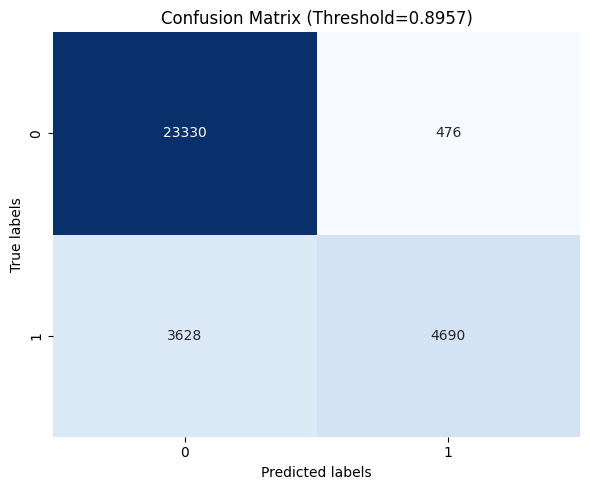

Displayed Confusion Matrix plot.
Logged Confusion Matrix plot artifact.
Logging classification report artifact...
Logged classification report artifact: classification_report_val.json
Logging the model...


2025/04/22 22:38:41 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Logged the trained model using mlflow.sklearn.
MLflow Run completed: ddd01d5ba7ac4ea2a72129a778d37407
View the run in the MLflow UI.


In [13]:
model = CatBoostClassifier(**best_hyperparameters)
log_classification_model(
        model=model,
        X_train=train_df.drop(columns=['customer_ID']),
        y_train=y_train['target'].values,
        X_val=val_df.drop(columns=['customer_ID']),
        y_val=y_val['target'].values,
        run_name="CatBoost HP Tuned - Val"
    )

Starting MLflow Run: CatBoost HP Tuned - Test (2eb408fa70ea403886a80db2033a7b35)
Logged model parameters.
Training the model...
Model training complete.
Evaluating the model on the validation set...
Attempting to find custom threshold using find_threshold_binary_search for Recall[0] >= 0.9800
Target Recall: >= 0.9800 for Class 0
Threshold found by Binary Search: 0.8987260
Achieved Recall at Threshold: 0.9800
Using threshold: Custom threshold 0.8987 aiming for Recall[0] >= 0.9800 (func achieved 0.9800)
Calculating performance metrics...
Validation Accuracy: 0.8683
Validation Weighted F1-Score: 0.8563
Validation Macro F1-Score: 0.8000
Validation Recall Class 0: 0.9800
Validation Recall Class 1: 0.5484
Validation Precision Class 0: 0.8613
Validation Precision Class 1: 0.9055

              precision    recall  f1-score   support

           0     0.8613    0.9800    0.9168    102026
           1     0.9055    0.5484    0.6831     35648

    accuracy                         0.8683    13767

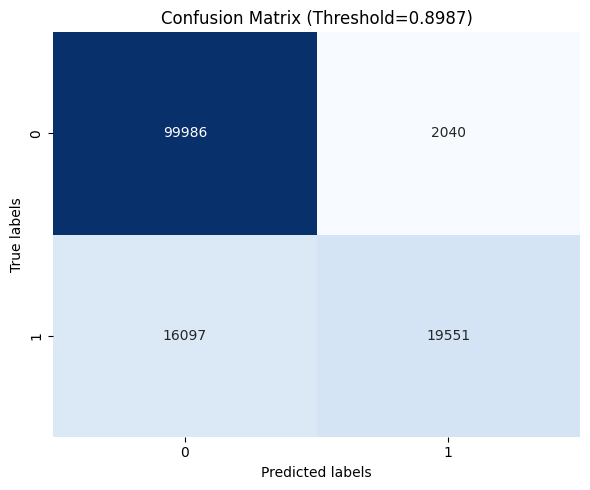

Displayed Confusion Matrix plot.
Logged Confusion Matrix plot artifact.
Logging classification report artifact...
Logged classification report artifact: classification_report_val.json
Logging the model...


2025/04/22 22:39:14 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Logged the trained model using mlflow.sklearn.
MLflow Run completed: 2eb408fa70ea403886a80db2033a7b35
View the run in the MLflow UI.


In [14]:
model = CatBoostClassifier(**best_hyperparameters)
log_classification_model(
        model=model,
        X_train=train_df.drop(columns=['customer_ID']),
        y_train=y_train['target'].values,
        X_val=test_df.drop(columns=['customer_ID']),
        y_val=y_test['target'].values,
        run_name="CatBoost HP Tuned - Test"
    )